In [6]:
from langchain_openai import ChatOpenAI
from langchain_pinecone import PineconeVectorStore
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from src.helper import download_hugging_face_embeddings
from dotenv import load_dotenv
import os
from src.prompt import *
load_dotenv()

PINECONE_API_KEY = os.environ.get('PINECONE_API_KEY')
OPENAI_AGENT_API_KEY = os.environ.get('OPENAI_AGENT_API_KEY')

embeddings = download_hugging_face_embeddings()
os.environ["OPENAI_AGENT_API_KEY"] = OPENAI_AGENT_API_KEY
llm = ChatOpenAI(temperature=0, model="gpt-4.1-mini", openai_api_key=OPENAI_AGENT_API_KEY)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)
embeddings = download_hugging_face_embeddings()
index_name = "medicalbot"
# index_name = "darrenchenhw"

# Embed each chunk and upsert the embeddings into your Pinecone index.
docsearch = PineconeVectorStore.from_existing_index(
    index_name=index_name,
    embedding=embeddings
)

retriever = docsearch.as_retriever(search_type="similarity", search_kwargs={"k": 3})

question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)



/Users/zfeng/Documents/fyp-github/FIT3199-FYP/bot_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Retriever Tool

## Retriever Tool Test

In [7]:
from langchain.tools import tool
from pydantic import BaseModel

class RagToolSchema(BaseModel):
    question: str

@tool(args_schema=RagToolSchema)
def retriever_tool(question):
    """Tool to Retrieve Semantically Similar documents to answer User Questions related to FutureSmart AI"""

    print("INSIDE RETRIEVER NODE")
    docsearch = PineconeVectorStore.from_existing_index(
    index_name=index_name,
    embedding=embeddings
)

    retriever = docsearch.as_retriever(search_type="similarity", search_kwargs={"k": 3})

    question_answer_chain = create_stuff_documents_chain(llm, prompt)
    rag_chain = create_retrieval_chain(retriever, question_answer_chain)
    response = rag_chain({"input": question})
    return response["answer"]

In [8]:

question = "What is stroke?"
docsearch = PineconeVectorStore.from_existing_index(
index_name=index_name,
embedding=embeddings
)

retriever = docsearch.as_retriever(search_type="similarity", search_kwargs={"k": 3})  
question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)
response = rag_chain.invoke({"input": question})
print(response["answer"])

Stroke is an acute focal neurological deficit caused by a vascular lesion with sudden onset, and symptoms lasting longer than 24 hours if the patient survives. For example, ischemic stroke results from a vascular occlusive lesion leading to sudden neurological deficits. Transient ischemic attack (TIA) differs as its neurological symptoms last less than 24 hours with complete recovery.


# ECG Visualizer

In [9]:
from langchain.tools import tool
import numpy as np
import matplotlib.pyplot as plt
import io
from pydantic import BaseModel
from langchain.tools import tool
class ECGToolSchema(BaseModel):
    question: str

@tool(args_schema=ECGToolSchema)
def visualize_ecg(question):
    """Tool to load ecg memmap numpy file and visualize the 12-lead ECG for a specific patient"""
    memmap_meta_path = "/Users/zfeng/Documents/fyp-github/FIT3199-FYP/ecg_dataset/memmap_meta.npz"
    memmap_path = "/Users/zfeng/Documents/fyp-github/FIT3199-FYP/ecg_dataset/memmap.npy"

    memmap_meta = np.load(memmap_meta_path, allow_pickle=True)
    memmap_data = np.memmap(memmap_path, dtype=np.float32, mode='r')

    starts = memmap_meta["start"]
    lengths = memmap_meta["length"]
    original_shape = tuple(memmap_meta["shape"][0])
    ecg_data = memmap_data.reshape(original_shape)

    # Function to visualize a 12-lead ECG
    def visualize_12lead_ecg(ecg_data, patient_index=0):
        # Get the start and length for this patient
        start_idx = starts[patient_index]
        length = lengths[patient_index]

        # Extract the data for this patient - all 12 leads
        patient_data = ecg_data[start_idx:start_idx+length, :]

        # Standard 12-lead ECG lead names
        lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

        # Create a figure with 12 subplots (3x4 grid)
        fig, axes = plt.subplots(3, 4, figsize=(15, 10))
        axes = axes.flatten()

        # Plot each lead
        for i, ax in enumerate(axes):
            if i < 12:  # We have 12 leads
                ax.plot(patient_data[:, i])
                ax.set_title(f'Lead {lead_names[i]}')
                ax.grid(True, alpha=0.3)

                # Add a small vertical scale bar (1 mV)
                # This is an approximation - normally would need calibration
                y_range = np.max(patient_data[:, i]) - np.min(patient_data[:, i])
                scale_bar = y_range * 0.2  # 20% of the range as a scale reference
                ax.plot([10, 10], [np.min(patient_data[:, i]), np.min(patient_data[:, i]) + scale_bar],
                    'k-', linewidth=2)

                # Remove tick labels to mimic clinical ECG appearance
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.axis('off')  # Hide unused subplot

        # Add a title for the entire plot
        plt.suptitle(f'12-Lead ECG - Patient #{patient_index+1}', fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)  # Adjust to make room for suptitle

        return fig

    # Visualize ECGs for first 3 patients
    for i in range(1):
        fig = visualize_12lead_ecg(ecg_data, i)
        plt.figure(fig.number)
        plt.savefig(f'patient_{i+1}_12lead_ecg.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Save to BytesIO object
    img = io.BytesIO()
    plt.savefig(img, format='png')
    img.seek(0)
    plt.close()
    
    return img

## ECG Visualizer Tool Test

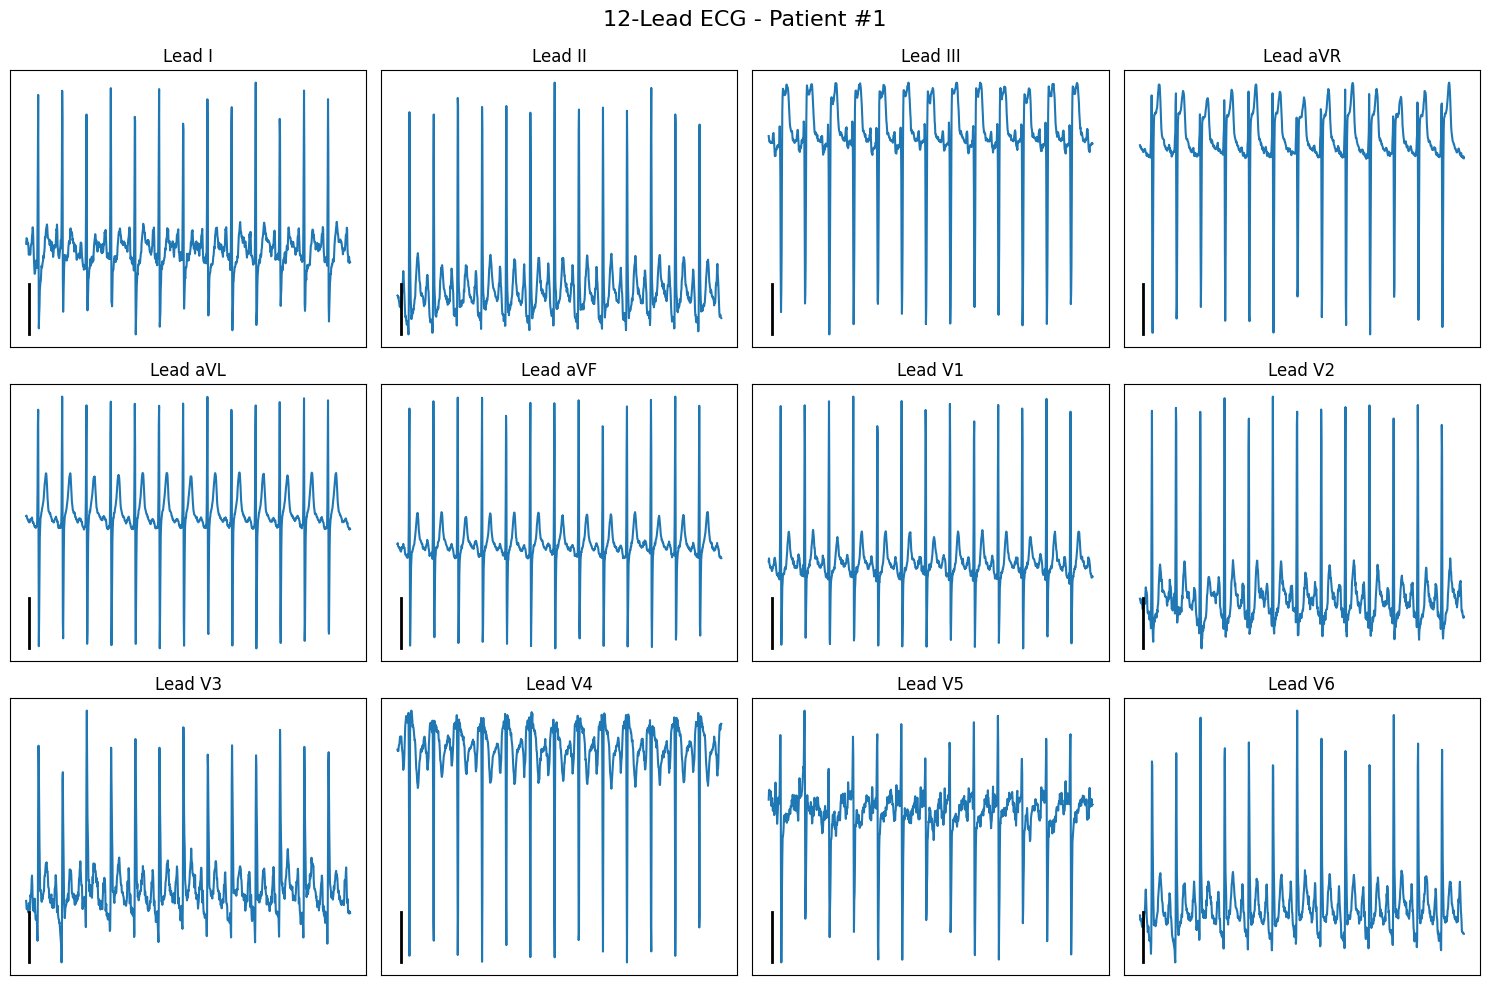

Answer: <_io.BytesIO object at 0x1749c4f90>


In [10]:
question = "Visualize the 12-lead ECG for patient 0"
result = visualize_ecg.invoke({"question": question})
print(f"Answer: {result}")


In [11]:
tools = [retriever_tool, visualize_ecg]
llm_with_tools = llm.bind_tools(tools)

# Combined

In [12]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]


In [13]:
from langgraph.prebuilt import ToolNode, tools_condition


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[retriever_tool, visualize_ecg])
graph_builder.add_node("tools", tool_node)

In [14]:
from langgraph.prebuilt import tools_condition

graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")


In [15]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

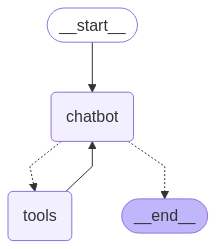

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
config = {"configurable": {"thread_id": "1"}}

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    for event in graph.stream({"messages": [("user", user_input)]}, config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


Assistant: Hello! How can I assist you today? If you have any questions or need help with something, feel free to ask.
